In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

Our job is to find the the area of the curve between two implicit surfaces, given by the equations bellow

In [2]:
f1 = lambda x,y,z : x**4+y*y/2+z*z-12
f2 = lambda x,y,z : x*x+y*y-4*z*z-8

To get a sense of how this two surfaces look like we try to plot them.

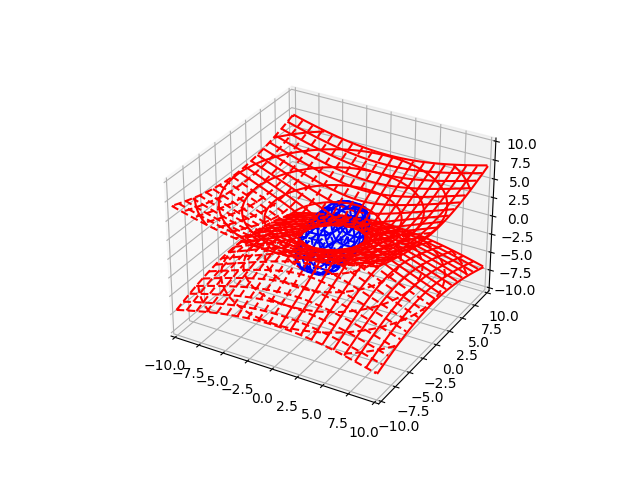

In [3]:
%matplotlib widget
def plot3DImplicit(ax, f, box, color='blue'):
  grid_res = np.arange(*box,0.1)
  grid_slices = np.linspace(*box,20)
  grid = np.meshgrid(grid_res, grid_res)

  for slice in grid_slices:
    x,y,z = grid[0], grid[1], slice
    ax.contour(x,y,f(x,y,z) + slice, [slice], zdir="z", colors=[color])
    
    x,y,z = grid[0], slice, grid[1]
    ax.contour(x,f(x,y,z) + slice, z, [slice], zdir="y", colors=[color])
    
    x,y,z = slice, grid[0], grid[1]
    ax.contour(f(x,y,z) + slice, y, z, [slice], zdir="x", colors=[color])

fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
box = (-10,10)

ax.set_xlim(box)
ax.set_zlim(box)
ax.set_ylim(box)

plot3DImplicit(ax,f1,box, 'blue')
plot3DImplicit(ax,f2,box, 'red')

Sadly with this plot is not easy to see how the curve is supposed to look like so we try to plot it by brute-force. We make a 3D point grid and filter only those points which lay close to both surfaces and plot them.

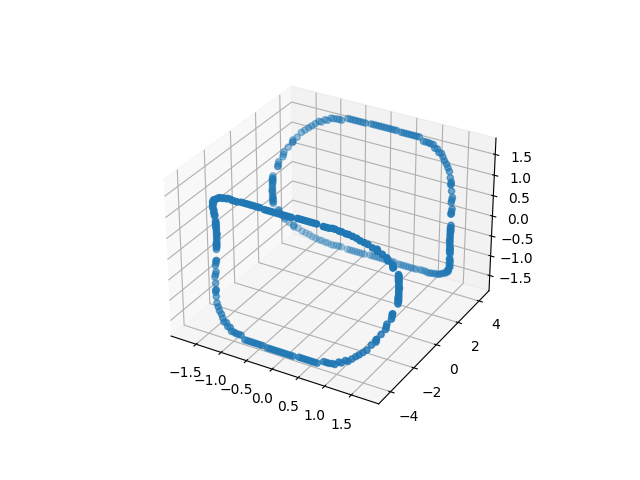

In [4]:
%matplotlib widget
box = (-10,10)
grid_res = np.arange(*box,0.05)
grid = np.array(np.meshgrid(grid_res, grid_res, grid_res))

x,y,z = grid[:,abs(f1(*grid)) + abs(f2(*grid)) < 0.3]

fig,ax = plt.subplots(subplot_kw={"projection":"3d"})
ax.scatter(x,y,z)

This plot is a lot clearer and we can see that there are actually two curves symmetric along the z-axis. While we could directly use this points to calculate the length by finding which points are consequent, this approach in not very efficient, so I've decided to use slightly different method. We can use the fact that $v=\nabla f_1 \times \nabla f_2$ points in the direction of the curve we are trying to find. So we can first find a single point that lays on the curve and then move in the direction of $v$.

To find a point on the curve $p$ I used simple gradient descent algorithm which minimizes the error function $||f_1 - f_2||^2$.

In [5]:
grad_f1 = lambda x,y,z : np.array([4 * x**3, y, 2 * z])
grad_f2 = lambda x,y,z : np.array([2 * x, 2 * y, -8 * z])

fi = lambda x,y,z : np.square(f1(x,y,z)) + np.square(f2(x,y,z)) # Error function
grad_fi = lambda x,y,z :  2 * f1(x,y,z) * grad_f1(x,y,z) + 2 * f2(x,y,z) * grad_f2(x,y,z)

In [6]:
def findIntersectionGrad(x,y,z, eps = 1e-10):
  p = np.array([x,y,z])
  while np.sqrt(fi(*p)) > eps:
    p = p - 0.001 * grad_fi(*p)
  return p

x,y,z = findIntersectionGrad(0.5 , 4.35, 1.65)
print(f"Intersection point: ({x:.2f}, {y:.2f}, {z:.2f})")

Intersection point: (0.49, 4.30, 1.64)


Now we find the curve by tracing the curve from $p$ in direction of $v$ until we form a closed loop. At the end we plot the curve.

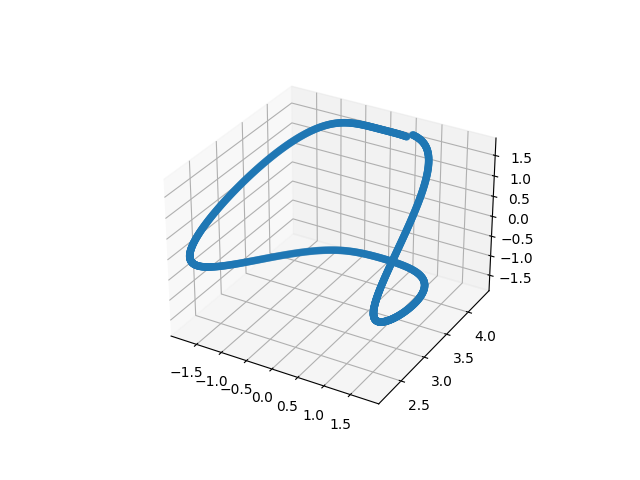

In [7]:
%matplotlib widget

cross_fi = lambda x,y,z : np.cross(grad_f1(x,y,z),grad_f2(x,y,z))


p0 = np.array([x,y,z])
points = [p0]

step = 0.0001 # Step that we move in the direction of v
bound = 0.1 # How close two points have to be to each other to decide we closed the loop
skip = int(np.ceil(bound / step)) # How many steps we skip in checking the closing of a loop. Needed because initial errors are smaller than `bound`

p = p0
err = np.Inf
for i in range(200000):
  p = p + step * cross_fi(*p)
  points.append(p)
  if i > skip:
    err = np.linalg.norm(p - p0)
  if err < bound:
    break

# We plot the obtained curve
fig,ax = plt.subplots(subplot_kw={"projection":"3d"})
points = np.array(points).T
ax.scatter(*points)

Now to get the length we just sum distances between two consequent points.

In [8]:
result = np.sum(np.linalg.norm(points[:,1:] - points[:,:-1],axis=0))
print(f"The length of a curve is {result:.2f}")

The length of a curve is 15.21
